# Full Inference Demo

In this demo, a full run of all necessary code is done to show it's use and and obtain the same results as mentioned in the paper/thesis


### 1 - Data Extraction

Here, we extract necessary data from CDAWEB, superposition and interpolate it, and then store it in hdf5 files for inference.

In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))


import pyspedas
from pyspedas import tplot, options, get_data
from Data.data_class import LoadArtemis, plot_electron_spectrogram
import pandas as pd
import torch

from Training.data_loader import MagnetotailDataset
from Helper.silence import silence_all
from tqdm import tqdm
import numpy as np
from Helper.shue_model import shue_magnetopause_xy
from Helper.plotting import plot_variables_from_sections
import matplotlib.pyplot as plt
from requests.exceptions import ConnectionError
from http.client import RemoteDisconnected
import time
from double_transformer_multi import DoubleTransformerMulti

# Create the CDAWeb interface object
cdaweb_obj = pyspedas.CDAWeb()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.1 Magnetotail Passing Time Extraction

1.1.1 Themis B data extraction

This cell extracts the time periods when the THEMIS B spacecraft is within -40 to 40 Re on the nightside of earth.

In [60]:
from tqdm import tqdm

# Start (is 2013-08-15 here, shortly before THEMIS B enters the -40 to 40 Re nightside region for the first time, after the initial data is given, all periods will be found automatically)
current_start = np.datetime64("2013-08-15")
current_end = current_start + np.timedelta64(20, 'D')

# Define ending year/month
end_year = 2014
end_month = 8

# Lists to store found orbit start and end times
orbit_start_str_B = []
orbit_end_str_B = []

dataset = 'THB_OR_SSC (2007-02-24 to 2025-08-31)'

# Function to retry network requests in case of non stable internet connection 
def retry_request(func, tries=10, delay=1):
    """Retry a network call a few times before failing."""
    for attempt in range(tries):
        try:
            return func()
        except (ConnectionError, RemoteDisconnected) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            if attempt == tries - 1:
                raise
            time.sleep(delay)


# Process each period from the approximate data
with tqdm(desc="Finding orbital periods") as pbar:
    while current_start <= np.datetime64(f"{end_year}-{end_month:02d}-01"):
        with silence_all():

            current_start_str = str(current_start)[:10]
            current_end_str = str(current_end)[:10]

            # Get files for this period
            urllist = retry_request(lambda: cdaweb_obj.get_filenames([dataset], current_start_str, current_end_str))
            retry_request(lambda: cdaweb_obj.cda_download(urllist, "cdaweb/"))
            
            true_data = get_data('XYZ_GSM')
            period_times = true_data.times
            period_pos = true_data.y
            
            # Apply time mask for this period
            time_mask = ((period_times*1e9).astype('datetime64[ns]') >= current_start) & ((period_times*1e9).astype('datetime64[ns]') <= current_end)
            period_times = period_times[time_mask]
            period_pos = period_pos[time_mask]
            
            # Apply spatial condition mask (nightside, -40 to 40 Re)
            spatial_mask = (period_pos[:, 1] >= -40) & (period_pos[:, 1] <= 40) & (period_pos[:, 0] <= -40)
            filtered_times = period_times[spatial_mask]
            
            if len(filtered_times) > 0:
                # Convert to datetime64 for easier manipulation
                filtered_times_dt = (filtered_times*1e9).astype('datetime64[ns]')
                
                # Get first entry and last exit for this period
                first_entry = filtered_times_dt[0]
                last_exit = filtered_times_dt[-1]
                
                # Add this period to our lists
                orbit_start_str_B.append(str(first_entry))
                orbit_end_str_B.append(str(last_exit))

            
        # Move to next period (advance by 25 days from first entry)
        pbar.update(1)
        pbar.set_postfix({"Periods found": len(orbit_start_str_B), "Current Start": str(current_start)[:10], "Current End": str(current_end)[:10]})
        
        current_end = first_entry + np.timedelta64(45, 'D')
        current_start = first_entry + np.timedelta64(25, 'D')
        

Finding orbital periods: 12it [00:27,  2.32s/it, Periods found=12, Current Start=2014-07-04, Current End=2014-07-24]


1.1.2 Themis C data extraction

This cell extracts the time periods when the THEMIS C spacecraft is within -40 to 40 Re on the nightside of earth.

In [61]:
from tqdm import tqdm

# Start (is 2013-08-15 here, shortly before THEMIS B enters the -40 to 40 Re nightside region for the first time, after the initial data is given, all periods will be found automatically)
current_start = np.datetime64(f"2013-08-15")
current_end = current_start + np.timedelta64(20, 'D')

end_year = 2014
end_month = 8

# Lists to store found orbit start and end times
orbit_start_str_C = []
orbit_end_str_C = []

dataset = 'THC_OR_SSC (2007-02-24 to 2025-08-31)'

def retry_request(func, tries=10, delay=2):
    """Retry a network call a few times before failing."""
    for attempt in range(tries):
        try:
            return func()
        except (ConnectionError, RemoteDisconnected) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            if attempt == tries - 1:
                raise
            time.sleep(delay)

# Process each period from the approximate data
with tqdm(desc="Finding orbital periods") as pbar:
    while current_start <= np.datetime64(f"{end_year}-{end_month:02d}-01"):
        with silence_all():

            current_start_str = str(current_start)[:10]
            current_end_str = str(current_end)[:10]

            # Get files for this period
            urllist = retry_request(lambda: cdaweb_obj.get_filenames([dataset], current_start_str, current_end_str))
            retry_request(lambda: cdaweb_obj.cda_download(urllist, "cdaweb/"))
            
            true_data = get_data('XYZ_GSM')
            period_times = true_data.times
            period_pos = true_data.y
            
            # Apply time mask for this period
            time_mask = ((period_times*1e9).astype('datetime64[ns]') >= current_start) & ((period_times*1e9).astype('datetime64[ns]') <= current_end)
            period_times = period_times[time_mask]
            period_pos = period_pos[time_mask]
            
            # Apply spatial condition mask (nightside, -40 to 40 Re)
            spatial_mask = (period_pos[:, 1] >= -40) & (period_pos[:, 1] <= 40) & (period_pos[:, 0] <= -40)
            filtered_times = period_times[spatial_mask]
            
            if len(filtered_times) > 0:
                # Convert to datetime64 for easier manipulation
                filtered_times_dt = (filtered_times*1e9).astype('datetime64[ns]')
                
                # Get first entry and last exit for this period
                first_entry = filtered_times_dt[0]
                last_exit = filtered_times_dt[-1]
                
                # Add this period to our lists
                orbit_start_str_C.append(str(first_entry))
                orbit_end_str_C.append(str(last_exit))

            
        # Move to next period (advance by 25 days from first entry)
        pbar.update(1)
        pbar.set_postfix({"Periods found": len(orbit_start_str_C), "Current Start": str(current_start)[:10], "Current End": str(current_end)[:10]})
        
        current_end = first_entry + np.timedelta64(45, 'D')
        current_start = first_entry + np.timedelta64(25, 'D')

Finding orbital periods: 12it [00:28,  2.35s/it, Periods found=12, Current Start=2014-07-04, Current End=2014-07-24]


1.2 Storing Data

Here the found periods of time for THEMIS B and C are used to extract information (plasma moments and magnetic field data) from CDAWEB and subsequently stored in hdf5 files

During this process, cdaweb data is downloaded in a cdaweb subdirectory, and will be stored there for future use. The first time, this process takes a long time (10 to 24 hours), afterwards expect half an hour when data is downloaded. Therefore, we will only take the first 6 months worth of data in this demo, (as denoted by the slicing in the for loop).

In [62]:
# Add magnetosheath parts from before magnetotail entries
for i in tqdm(range(1, 8)):
  try:

    with silence_all():

      curr_data_class = LoadArtemis(start_time =orbit_start_str_B[i], 
                    end_time   = orbit_end_str_B[i],
                    satellite_list=['THB']
                      )

      curr_data_class.convert_min_delta_all(start_time        = orbit_start_str_B[i],
                          end_time          =  orbit_end_str_B[i],
                          dt_method         ='max', 
                          custom_time_delta = 600)

      curr_data_class.extract_to_HDF5('generation_data/artemis_P1_full.h5')
  except Exception as e:
    print(f"Could not process period {i}: {e}")


100%|██████████| 7/7 [09:22<00:00, 80.36s/it] 


In [63]:
# Add magnetosheath parts from before magnetotail entries
for i in tqdm(range(1, 8)):
  try:  
    with silence_all():

      curr_data_class = LoadArtemis(start_time = orbit_start_str_C[i], 
                                    end_time   = orbit_end_str_C[i],
                                    satellite_list = ['THC']
                                      )

      curr_data_class.convert_min_delta_all(  start_time        = orbit_start_str_C[i],
                                              end_time          =  orbit_end_str_C[i],
                                              dt_method         ='max', 
                                              custom_time_delta = 600)

      curr_data_class.extract_to_HDF5('generation_data/artemis_P2_full.h5')
  except Exception as e:
    print(f"Error processing index {i}: {e}")
    continue

100%|██████████| 7/7 [10:15<00:00, 87.90s/it] 


1.3 Loading HDF5 files

One the previous cells have been run succesfully once, no reruns are needed.
Here we load the HDF5 Files, and remove any sections that are shorter than 10 timestamps.


In [73]:
# PREDICT DATASET 1
file_path = Path('..') / "Training" / "generation_data" / "artemis_P1_full.h5"
abs_file_path_B = file_path.resolve()

# Create dataset
generation_dataset_B = MagnetotailDataset(abs_file_path_B)

B_session_info = generation_dataset_B.get_session_info()

for session_idx in range(len(B_session_info)):
    n_sections_removed_B = 0

    if B_session_info[session_idx]['num_timestamps'] < 10:
        generation_dataset_B.delete_section('section_' + str(session_idx).zfill(3))
        n_sections_removed_B += 1

print(f"Removed {n_sections_removed_B} sections due to insufficient data.")

generation_samples_B = generation_dataset_B.get_trainable_samples()

Setting trainable samples for each section...


100%|██████████| 9/9 [00:00<00:00, 160.44it/s]


Computing plasma beta for each section...


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 9/9 [00:00<00:00, 8998.51it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 9/9 [00:00<00:00, 15827.56it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 9/9 [00:00<00:00, 8622.37it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 9/9 [00:00<00:00, 8469.54it/s]

Removed 0 sections due to insufficient data.


In [74]:
# PREDICT DATASET 1
file_path = Path('..') / "Training" / "generation_data" / "artemis_P2_full.h5"
abs_file_path_C = file_path.resolve()

# Create dataset
generation_dataset_C = MagnetotailDataset(abs_file_path_C)

C_session_info = generation_dataset_B.get_session_info()

for session_idx in range(len(C_session_info)):
    n_sections_removed_C = 0
    if C_session_info[session_idx]['num_timestamps'] < 10:
        generation_dataset_C.delete_section('section_' + str(session_idx).zfill(3))
        n_sections_removed_C += 1

print(f"Removed {n_sections_removed_C} sections due to insufficient data.")
        
generation_samples_C = generation_dataset_C.get_trainable_samples()

    

Setting trainable samples for each section...


100%|██████████| 7/7 [00:00<00:00, 114.81it/s]


Computing plasma beta for each section...


100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 7/7 [00:00<00:00, 17591.45it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 7/7 [00:00<00:00, 4646.33it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 7/7 [00:00<?, ?it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 7/7 [00:00<?, ?it/s]

Removed 0 sections due to insufficient data.


### 2 - Crossing Detection

2.1 Model Creation

The parameters for the model shown here are the standard parameters, when loading other models, different parameters may be needed. Error messages tell what parameters need to be changed.

In [75]:
data_types = ['ion_eflux', 'ion_avgtemp', 'ion_density', 'ion_velocity_magnitude', 'magnetic_field_gsm_x']

# Create and load model (standard model parameters for all provided models)
model = DoubleTransformerMulti(
    input_dim                   = 31,
    timestamps                  = 1, # Adapt to model used
    d_model                     = 64,
    nhead                       = 2,
    num_encoder_layers          = 2,
    num_decoder_layers          = 2,
    dim_feedforward             = 64,
    mask_ratio                  = 0.4,
    patches_per_timestamp_spect = 8,
    n_vectors                   = 0,
    n_scalars                   = 4,
    data_types                  = data_types,
    device                      = 'cuda' if torch.cuda.is_available() else 'cpu',
    window_average_data         = 3,
    mask_scalars                = True
)

model.load_models('models/1_steps_vel_mag_mask/tail_avg3.pth', 'models/1_steps_vel_mag_mask/sheath_avg3.pth')

Padding input_dim from 31 to 32 to make it divisible by 8
Created 126 deterministic noise patterns for single timestamp
Padding input_dim from 31 to 32 to make it divisible by 8


2.2 Results generation

2.2.1 Model usage for results generation

In [76]:
generation_results_B = model.get_results(generation_samples_B, crossing_times=None, window_average_errors=3)
generation_results_C = model.get_results(generation_samples_B, crossing_times=None, window_average_errors=3)

# Get predicted crossing times
predicted_crossing_times_norm_B = np.sort(np.array(generation_results_B['zero_crossing_times_normalized']))
predicted_crossing_times_norm_C = np.sort(np.array(generation_results_C['zero_crossing_times_normalized']))

2.2.1 Getting satellite positions during magnetotail passes

In [77]:
end_time =  str(predicted_crossing_times_norm_B[-1])
start_time =  str(predicted_crossing_times_norm_B[0])
cdaweb_obj = pyspedas.CDAWeb()

print(f"Start time: {start_time}, End time: {end_time}")
dataset = 'THB_OR_SSC (2007-02-24 to 2025-08-31)'

# Get the list of files for the specified time range
urllist = cdaweb_obj.get_filenames([dataset],start_time, end_time)
cdaweb_obj.cda_download(urllist,"cdaweb/", varnames=['XYZ_GSE'])

true_data_B = get_data('XYZ_GSE')

true_data_times_B = true_data_B.times 
true_data_pos_B = true_data_B.y

Start time: 2013-09-16T21:43:15.334892970, End time: 2014-03-18T08:33:07.726968273


04-Nov-25 14:42:54: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20130901_v01.cdf
04-Nov-25 14:42:54: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131001_v01.cdf
04-Nov-25 14:42:55: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131101_v01.cdf
04-Nov-25 14:42:55: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131201_v01.cdf
04-Nov-25 14:42:56: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2014\thb_or_ssc_20140101_v01.cdf
04-Nov-25 14:42:56: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2014\thb_or_ssc_20140201_v01.cdf
04-Nov-25 14:42:57: File is curren

In [78]:
end_time =  str(predicted_crossing_times_norm_C[-1])
start_time =  str(predicted_crossing_times_norm_C[0])

print(f"Start time: {start_time}, End time: {end_time}")
dataset = 'THC_OR_SSC (2007-02-24 to 2025-08-31)'

# Get the list of files for the specified time range
urllist = cdaweb_obj.get_filenames([dataset],start_time, end_time)
cdaweb_obj.cda_download(urllist, "cdaweb/", varnames=['XYZ_GSE'])

true_data_C = get_data('XYZ_GSE')

true_data_times_C = true_data_C.times 
true_data_pos_C = true_data_C.y

Start time: 2013-09-16T21:43:15.334892970, End time: 2014-03-18T08:33:07.726968273


04-Nov-25 14:43:02: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20130901_v01.cdf
04-Nov-25 14:43:03: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131001_v01.cdf
04-Nov-25 14:43:04: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131101_v01.cdf
04-Nov-25 14:43:04: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131201_v01.cdf
04-Nov-25 14:43:05: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2014\thc_or_ssc_20140101_v01.cdf
04-Nov-25 14:43:05: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2014\thc_or_ssc_20140201_v01.cdf
04-Nov-25 14:43:06: File is curren

2.2.2 Getting positions of crossings in GSE coordinates

In [79]:
# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric_B = (true_data_times_B * 1e9).astype('datetime64[ns]').astype(np.int64)
predicted_times_numeric_B = predicted_crossing_times_norm_B.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
predicted_positions_B = np.zeros((len(predicted_crossing_times_norm_B), true_data_pos_B.shape[1]))

for i in range(true_data_pos_B.shape[1]):
    predicted_positions_B[:, i] = np.interp(predicted_times_numeric_B, data_times_numeric_B, true_data_pos_B[:, i])


In [80]:
# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric_C = (true_data_times_C * 1e9).astype('datetime64[ns]').astype(np.int64)
predicted_times_numeric_C = predicted_crossing_times_norm_C.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
predicted_positions_C = np.zeros((len(predicted_crossing_times_norm_C), true_data_pos_C.shape[1]))

for i in range(true_data_pos_C.shape[1]):
    predicted_positions_C[:, i] = np.interp(predicted_times_numeric_C, data_times_numeric_C, true_data_pos_C[:, i])

2.2.3 Convert positions into aSWGSM coordinate frame

In [82]:
from Helper.cotrans import GSE_to_aSWGSM_array

# Get dipole tilt angle of all data points for B
predicted_positions_B_aGSM, aberration_y_array_B, aberration_z_array_B = GSE_to_aSWGSM_array(predicted_positions_B, predicted_crossing_times_norm_B)

# Get dipole tilt angle of all data points for C
predicted_positions_C_aGSM, aberration_y_array_C, aberration_z_array_C  = GSE_to_aSWGSM_array(predicted_positions_C, predicted_crossing_times_norm_C)

04-Nov-25 14:43:20: ['geo', 'gei', 'gse']
04-Nov-25 14:43:20: Running transformation: subgeo2gei
04-Nov-25 14:43:20: Running transformation: subgei2gse
04-Nov-25 14:43:20: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
04-Nov-25 14:43:21: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130901_v01.cdf
04-Nov-25 14:43:21: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
04-Nov-25 14:43:22: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131001_v01.cdf
04-Nov-25 14:43:22: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
04-Nov-25 14:43:23: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131101_v01.cdf
04-Nov-25 14:43:23: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
04-Nov-25 14:43:24: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131201_v01.cdf
04-Nov-25 14:43:24: Down

2.2.4 Removing 'crossings' that could have been lunar wake entries and exits

In [83]:
from Helper.moon import lunar_wake_check_series

### REMOVE CROSSINGS IN LUNAR WAKE ###  
times_crossing_B = [str(time.astype('datetime64[s]')) for time in predicted_crossing_times_norm_B]
crossings_in_wake_B = lunar_wake_check_series(predicted_positions_B, times_crossing_B, aberration_y_array_B, aberration_z_array_B)

# Removal
predicted_crossing_times_norm_B = predicted_crossing_times_norm_B[~np.array(crossings_in_wake_B)]
predicted_positions_B_aGSM = predicted_positions_B_aGSM[~np.array(crossings_in_wake_B)]

### REMOVE CROSSINGS IN LUNAR WAKE ###  
times_crossing_C = [str(time.astype('datetime64[s]')) for time in predicted_crossing_times_norm_C]
crossings_in_wake_C = lunar_wake_check_series(predicted_positions_C, times_crossing_C, aberration_y_array_C, aberration_z_array_C)

# Removal
predicted_crossing_times_norm_C = predicted_crossing_times_norm_C[~np.array(crossings_in_wake_C)]
predicted_positions_C_aGSM = predicted_positions_C_aGSM[~np.array(crossings_in_wake_C)]

In [84]:
predicted_positions = np.vstack((predicted_positions_B_aGSM, predicted_positions_C_aGSM))

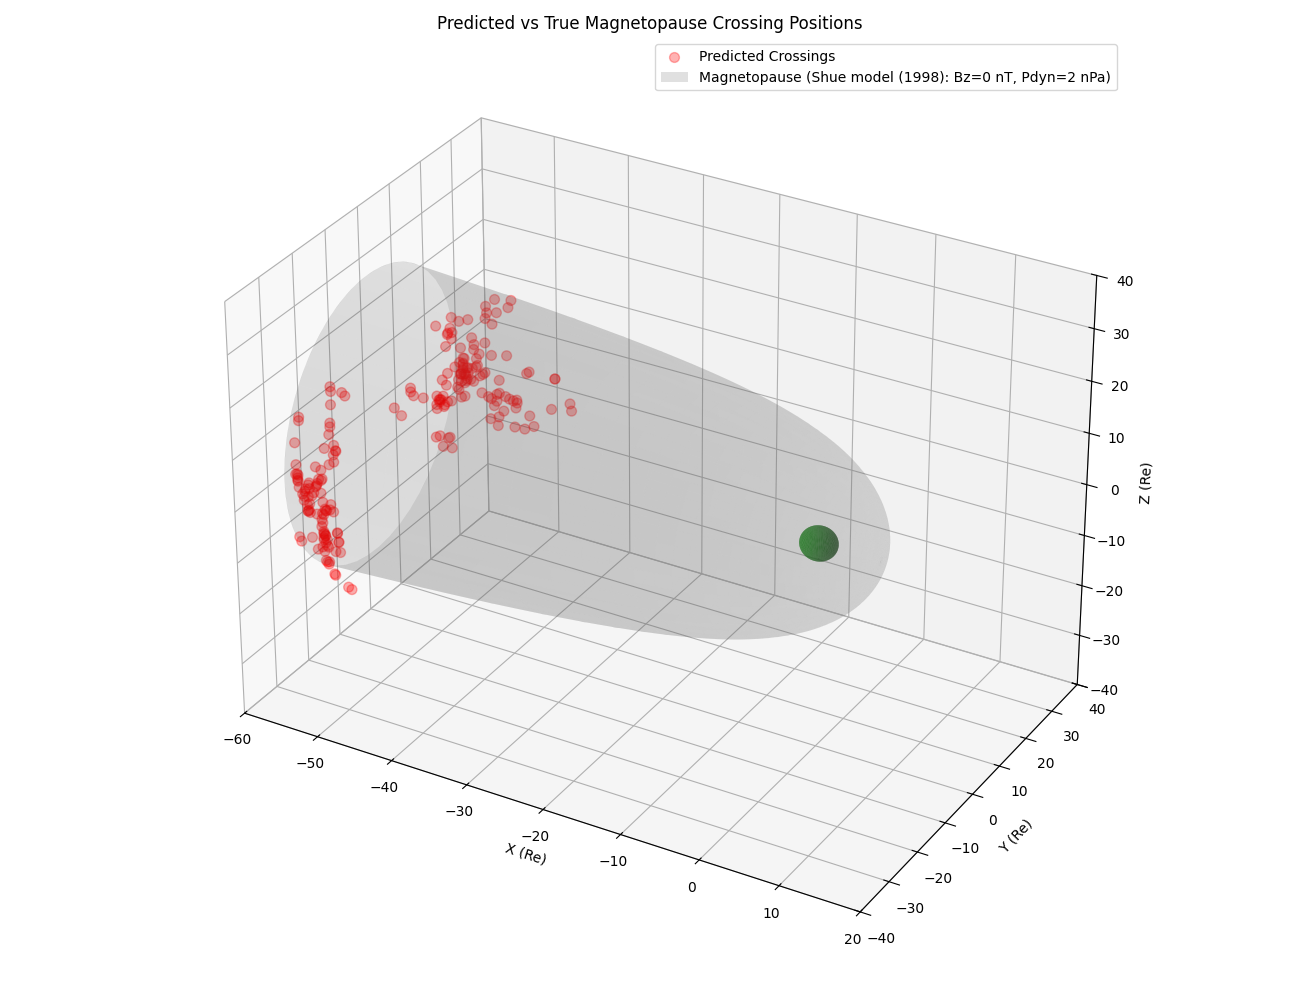

In [86]:
from Helper.shue_model import shue_magnetopause_surface

%matplotlib widget
plt.close()
import matplotlib.lines as mlines
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, projection='3d')

# Create Earth sphere with radius of 1 Re
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)

# Plot predicted positions
ax.scatter(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], 
           c='red', s=50, alpha=0.3, label='Predicted Crossings')



# Plot spacecraft trajectory
# ax.plot(true_data_pos[:, 0], true_data_pos[:, 1], true_data_pos[:, 2], 
#         c='black', alpha=0.1, label='Spacecraft Trajectory')

# Set labels
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.set_zlabel('Z (Re)')

# Set equal aspect ratio for all axes
box_aspect = [3/2,1,1]  # Different aspect ratio
ax.set_box_aspect(box_aspect)

# Set axis limits based on data range
xlim = [-70, 20]
ylim = [-40, 40]
zlim = [-40, 40]
ax.set_xlim([-60, 20])
ax.set_ylim([-40, 40])
ax.set_zlim([-40, 40])

# Build the magnetopause surface (using your axis limits)
mp_x, mp_y, mp_z = shue_magnetopause_surface(Bz_nT=0.0, Pdyn_nPa=2.0,
                                             Xmin=-80, Xmax=xlim[1])

# Apply the same visual x-stretch you used for the Earth sphere
x_stretch = (box_aspect[1] / box_aspect[0]) * ((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]))
mp_x_plot = mp_x * x_stretch

# Draw the surface
ax.plot_surface(mp_x_plot, mp_y, mp_z, alpha=0.15, linewidth=0, color='gray', label='Magnetopause (Shue model (1998): Bz=0 nT, Pdyn=2 nPa)')

# Add a legend entry for the surface (plot_surface doesn't auto-legend)
mp_proxy = mlines.Line2D([], [], color='gray', lw=6, alpha=0.6,
                         label='Magnetopause (Shue model: Bz=0 nT, Pdyn=2 nPa)')
handles, labels = ax.get_legend_handles_labels()
handles.append(mp_proxy)
labels.append(mp_proxy.get_label())
ax.legend(handles, labels)

stretch = box_aspect[1]/ box_aspect[0]  # Stretch factor for x-axis

# Earth radius in Re (Earth radii) - 1 Re
earth_radius = 3.0
earth_x = earth_radius * np.outer(np.cos(u), np.sin(v))*stretch*(np.diff(xlim)/np.diff(ylim))
earth_y = earth_radius * np.outer(np.sin(u), np.sin(v))
earth_z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot Earth as a blue sphere
ax.plot_surface(earth_x, earth_y, earth_z, color='green', alpha=0.6)
ax.legend()
ax.set_title('Predicted vs True Magnetopause Crossing Positions')
plt.tight_layout()
plt.show()

array(['2013-12-19T18:09:09.449693638', '2013-12-20T19:18:16.119955307',
       '2013-12-20T19:37:51.211262073'], dtype='datetime64[ns]')